## Homework 4

In [134]:
%run /home/fer/Documents/personalCourses/ML-Zoomcamp/ml-zoomcamp/utils.py

<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [4]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

raw_df.columns = raw_df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(raw_df.dtypes[raw_df.dtypes == 'object'].index)

for c in categorical_columns:
    raw_df[c] = raw_df[c].str.lower().str.replace(' ', '_')



In [5]:
columns_use = [
    'make', 'model', 'year', 'engine_hp', 
    'engine_cylinders', 'transmission_type', 
    'vehicle_style', 'highway_mpg', 
    'city_mpg', 'msrp'
]

In [6]:
# Working with dataframe without raw_df
df = raw_df.copy()

### Data 

- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

In [7]:
df = df[columns_use]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11845 non-null  float64
 4   engine_cylinders   11884 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [9]:
# Missing values
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [10]:
df[["engine_hp", "engine_cylinders"]] = df[["engine_hp", "engine_cylinders"]].fillna(0)

In [11]:
# MAKE PRICE BINARY
above_average = [ 1 if item > df.msrp.mean() else 0 for item in df.msrp ]
msrp_original = df["msrp"]
df["msrp"] = above_average

In [12]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0


**Split the data into: train/validation/test 60%/20%/20%**

In [13]:
# Full_Train and test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# train and validation
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
# Shuffing indices and getting "y" variables
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.msrp.values
y_val = df_val.msrp.values
y_test = df_test.msrp.values

In [16]:
del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

### Q1: ROC AUC feature importance

In [17]:
# Numerical variable
numerical_columns = list(df_train.dtypes[df_train.dtypes != 'object'].index)
numerical_columns

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [18]:
for col in numerical_columns:
    score = roc_auc_score(y_train, df_train[col])

    # AUC < 0.5
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col])
    
    print(col)
    print("\t ROC AUC Score: %.4f\n" %(score))
    pass

year
	 ROC AUC Score: 0.6876

engine_hp
	 ROC AUC Score: 0.9171

engine_cylinders
	 ROC AUC Score: 0.7661

highway_mpg
	 ROC AUC Score: 0.6331

city_mpg
	 ROC AUC Score: 0.6734



The highest AUC is in the variable: "engine_hp"


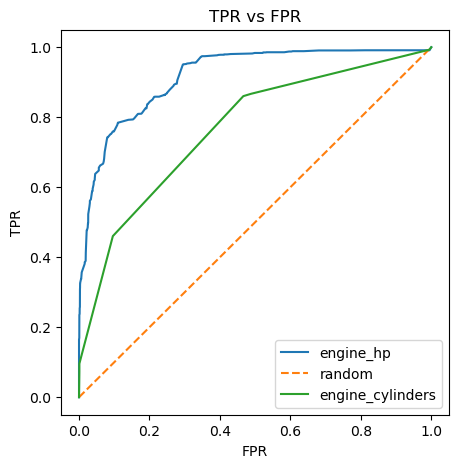

In [19]:
# Plotting the 2 most highest auc
fpr, tpr, _ = roc_curve(y_train, df_train.engine_hp)

plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label="engine_hp")
plt.plot([0, 1], [0,1], label="random", linestyle="--")

fpr, tpr, _ = roc_curve(y_train, df_train.engine_cylinders)
plt.plot(fpr, tpr, label="engine_cylinders")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("TPR vs FPR")
plt.show()

Here, we can validate that "engine_hp" is the better model for this question, for train dataset

### Q2: Training the model

In [29]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [30]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]

In [31]:
auc = roc_auc_score(y_val, y_pred)

In [32]:
print("The AUC of this model on validation dataset is: ", auc)

The AUC of this model on validation dataset is:  0.976576055523424


### Q3: Precision and Recall

- Precision: $P=\frac{TP}{TP+FP}$
- Recall/TPR: $R=\frac{TP}{TP + FN}$

In [44]:
thresholds = np.linspace(0.0, 1.0, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ["threshold", "tp", "fp", "fn", "tn"]
df_scores = pd.DataFrame(scores, columns=columns)

# Compute precision and recall
df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [45]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,643,345,11,1384,0.650810,0.983180
20,0.2,622,218,32,1511,0.740476,0.951070
30,0.3,606,159,48,1570,0.792157,0.926606
40,0.4,588,109,66,1620,0.843615,0.899083
50,0.5,567,76,87,1653,0.881804,0.866972
60,0.6,522,49,132,1680,0.914186,0.798165
70,0.7,490,36,164,1693,0.931559,0.749235
80,0.8,440,17,214,1712,0.962801,0.672783
90,0.9,347,4,307,1725,0.988604,0.530581


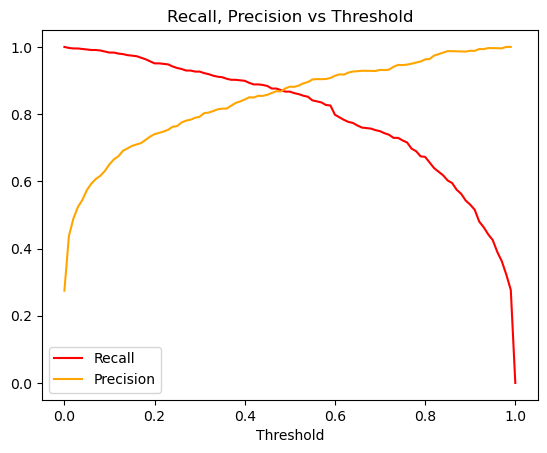

In [46]:
# Plot Precision and Recall
plt.plot(df_scores.threshold, df_scores.recall, c="red", label="Recall")
plt.plot(df_scores.threshold, df_scores.precision, c="orange", label="Precision")
plt.legend()
plt.title("Recall, Precision vs Threshold")
plt.xlabel("Threshold")
plt.show()

In [61]:
intersection =  df_scores[(np.round(df_scores.precision, 2) == np.round(df_scores.recall, 2))]
intersection

,threshold,tp,fp,fn,tn,precision,recall
48,0.48,570,87,84,1642,0.86758,0.87156


The intersect between Precision and Recall is the threshold: 0.48

### Q4: F1 Score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

In [82]:
df_scores["f1"] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)


In [123]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.500000
tp            567.000000
fp             76.000000
fn             87.000000
tn           1653.000000
precision       0.881804
recall          0.866972
f1              0.874325
Name: 50, dtype: float64

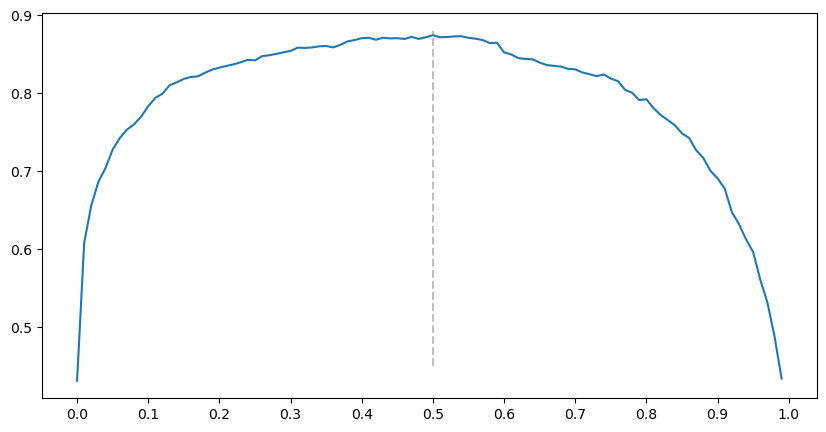

In [128]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.5, 0.45, 0.88, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

### Q5: 5-Fold CV / k-Folds

In [87]:
from tqdm.auto import tqdm

In [100]:
df_full_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
2711,mercedes-benz,clk-class,2007,382.0,8.0,automatic,coupe,22,15,1
333,nissan,370z,2016,332.0,6.0,manual,coupe,26,18,0
9377,gmc,sierra_1500,2017,285.0,6.0,automatic,extended_cab_pickup,24,18,0
939,porsche,911,2016,350.0,6.0,manual,convertible,26,19,1
5675,volkswagen,gti,2013,200.0,4.0,manual,4dr_hatchback,31,21,0
...,...,...,...,...,...,...,...,...,...,...
7813,audi,q5,2016,272.0,6.0,automatic,4dr_suv,26,18,1
10955,toyota,tundra,2015,381.0,8.0,automatic,crew_cab_pickup,17,13,1
905,saab,900,1997,150.0,4.0,manual,4dr_hatchback,26,18,0
5192,pontiac,g6,2009,164.0,4.0,automatic,coupe,33,22,0


In [139]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.msrp.values
    y_val = df_val.msrp.values

    del df_train["msrp"]
    del df_val["msrp"]
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)


In [140]:
print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

0.980 +- 0.002


### Q6: Hyperparameter Tuning

In [24]:
#df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
#df.totalcharges = df.totalcharges.fillna(0)

#df.churn = (df.churn == 'yes').astype(int)